# PS Parallel Programming / Sheet 06
# Fabio Valentini / MN 01018782

In [1]:
# initial setup

import subprocess

from IPython.display import HTML, set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import parse

%matplotlib inline
set_matplotlib_formats('svg')

SAMPLE_SIZE = 10
THREADS = 16

## Exercise 1: Exclusive Prefix Sum

- sequential program: `./presum/presum_seq.c`
- parallel OpenMP program: `./presum/presum_par.c`

### Local Performance Measurements

In [2]:
parser = parse.Parser("result: {result:d}, time: {time:.f} seconds")

sequentials = []

# run sequential exlusive prefix-sum implementation
for i in range(SAMPLE_SIZE):
    ret = subprocess.run(
    ["./presum/presum_seq", "1000000000"],
    stdout=subprocess.PIPE,
    )
    sequentials.append(parser.parse(ret.stdout.decode())["time"])

sequential_fastest = np.array(sequentials).min()

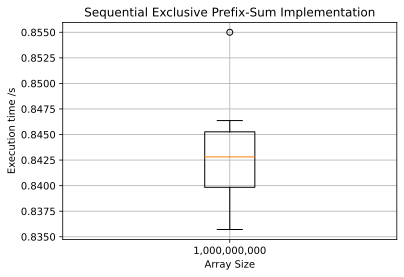

In [3]:
plt.boxplot([sequentials], labels=["1,000,000,000"])

plt.title("Sequential Exclusive Prefix-Sum Implementation")
plt.xlabel("Array Size")
plt.ylabel("Execution time /s")

plt.grid()
plt.show()

The sequential algorithm had very predictable performance with few outliers.

In [4]:
parallels = []

threads = [*range(1, THREADS+1)]

# run parallelized exclusive prefix-sum implementation
for p in threads:
    ret = subprocess.run(
        ["./presum/presum_par", "1000000000"],
        env={"OMP_NUM_THREADS": str(p)},
        stdout=subprocess.PIPE,
    )
    parallels.append(parser.parse(ret.stdout.decode())["time"])

speedups = sequential_fastest / parallels

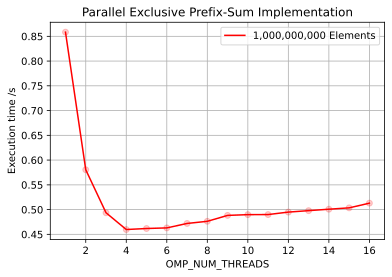

In [5]:
plt.plot(threads, parallels, "ro", alpha=0.2)
plt.plot(threads, parallels, "r-", label="1,000,000,000 Elements")

plt.title("Parallel Exclusive Prefix-Sum Implementation")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")

plt.legend()
plt.grid()
plt.show()

On my local system, the best execution time was consistently achieved with 4 or 5 threads. Since the calculations themselves were fast, I assume that this is caused by runtime thread management overhead outpacing the performance gain for higher numbers of threads. Running the algorithm with bigger arrays might have helped explain this behaviour, but at this point system memory was the limiting factor (making the arrays only 10x bigger already didn't work on my system with 32GB RAM).

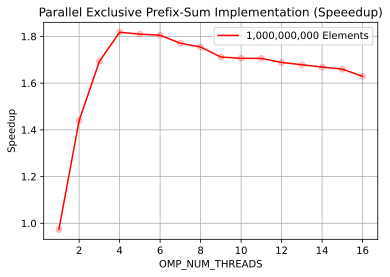

In [6]:
plt.plot(threads, speedups, "ro", alpha=0.2)
plt.plot(threads, speedups, "r-", label="1,000,000,000 Elements")

plt.title("Parallel Exclusive Prefix-Sum Implementation (Speeedup)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Speedup")

plt.legend()
plt.grid()
plt.show()

In [7]:
data = np.array([threads, parallels, speedups]).T

df = pd.DataFrame(
    data,
    index=threads,
    columns=[
        "OMP_NUM_THREADS",
        "Execution time /s",
        "Speedup",
    ],
)

HTML(df.to_html(index=False))

OMP_NUM_THREADS,Execution time /s,Speedup
1.0,0.858417,0.973546
2.0,0.580538,1.439542
3.0,0.493644,1.692937
4.0,0.459731,1.817822
5.0,0.461813,1.809624
6.0,0.463015,1.804928
7.0,0.472000,1.770569
8.0,0.476346,1.754415
9.0,0.488267,1.711580
10.0,0.489806,1.706204


### LCC2 Performance Measurements

- job script: `./presum/sheet_06_1.job.sh`
- job output: `./presum/sheet_06_1.dat`

In [8]:
lcc2_sequentials = [
    8.194122076,
    8.189934254,
    8.181318283,
    8.219448328,
    8.190007925,
]

lcc2_sequential_fastest = np.array(lcc2_sequentials).min()

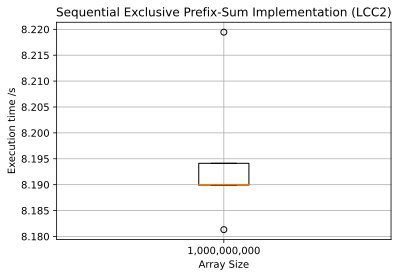

In [9]:
plt.boxplot([lcc2_sequentials], labels=["1,000,000,000"])

plt.title("Sequential Exclusive Prefix-Sum Implementation (LCC2)")
plt.xlabel("Array Size")
plt.ylabel("Execution time /s")

plt.grid()
plt.show()

In [10]:
lcc2_threads = [*range(1, 8+1)]

lcc2_parallels = [
    8.215678237,
    5.203491576,
    3.726963229,
    3.261528399,
    3.033638578,
    2.746852156,
    2.718711659,
    2.607410312,
]

lcc2_speedups = lcc2_sequential_fastest / lcc2_parallels

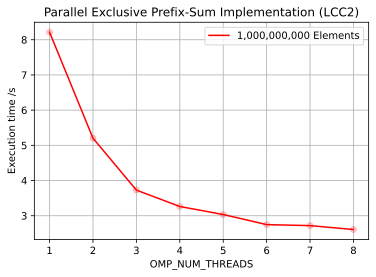

In [11]:
plt.plot(lcc2_threads, lcc2_parallels, "ro", alpha=0.2)
plt.plot(lcc2_threads, lcc2_parallels, "r-", label="1,000,000,000 Elements")

plt.title("Parallel Exclusive Prefix-Sum Implementation (LCC2)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")

plt.legend()
plt.grid()
plt.show()

Compared to the measurements on my local system, this shows a much better scaling behaviour with more threads. However, the performance for the sequential and single-threaded parallel program was already slower by a factor of 10 on LCC2. I assume that the performance of integer arithmetic is slower on LCC2, such that the benefit of adding more threads always outweighs their runtime management cost for arrays of this size.

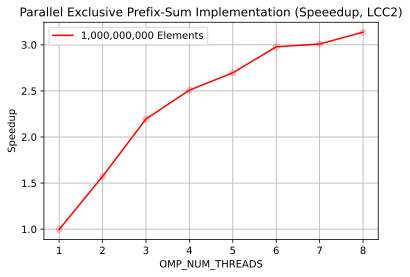

In [12]:
plt.plot(lcc2_threads, lcc2_speedups, "ro", alpha=0.2)
plt.plot(lcc2_threads, lcc2_speedups, "r-", label="1,000,000,000 Elements")

plt.title("Parallel Exclusive Prefix-Sum Implementation (Speeedup, LCC2)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Speedup")

plt.legend()
plt.grid()
plt.show()

The achievable speedup on LCC2 was also much better than on my local system (over 3 for 8 threads on LCC2, compared to below 2 for any number of threads locally).

In [13]:
data = np.array([lcc2_threads, lcc2_parallels, lcc2_speedups]).T

df = pd.DataFrame(
    data,
    index=lcc2_threads,
    columns=[
        "OMP_NUM_THREADS",
        "Execution time /s",
        "Speedup",
    ],
)

HTML(df.to_html(index=False))

OMP_NUM_THREADS,Execution time /s,Speedup
1.0,8.215678,0.995818
2.0,5.203492,1.572275
3.0,3.726963,2.195170
4.0,3.261528,2.508431
5.0,3.033639,2.696867
6.0,2.746852,2.978434
7.0,2.718712,3.009263
8.0,2.607410,3.137718


## Hardware + Software

- CPU: AMD Ryzen 7 5800X (8 Cores, 16 Threads)
- RAM: 4 x 8GB Gskill TridentZ 3200 MHz (CL14-14-14-34)
- OS: Fedora Workstation 34
- Compiler: `gcc (GCC) 11.1.1 20210428 (Red Hat 11.1.1-1)`
- Report: Python 3.9.4, Jupyter Notebook 6.1.6, IPython 7.20.0, ipykernel 5.4.3, numpy 1.20.1, matplotlib 3.4.1, pandas 1.2.1